In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchviz import make_dot as dot
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

In [214]:
#https://www.kaggle.com/code/desalegngeb/heart-disease-predictions/notebook

data=pd.read_csv("Heart.csv")
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


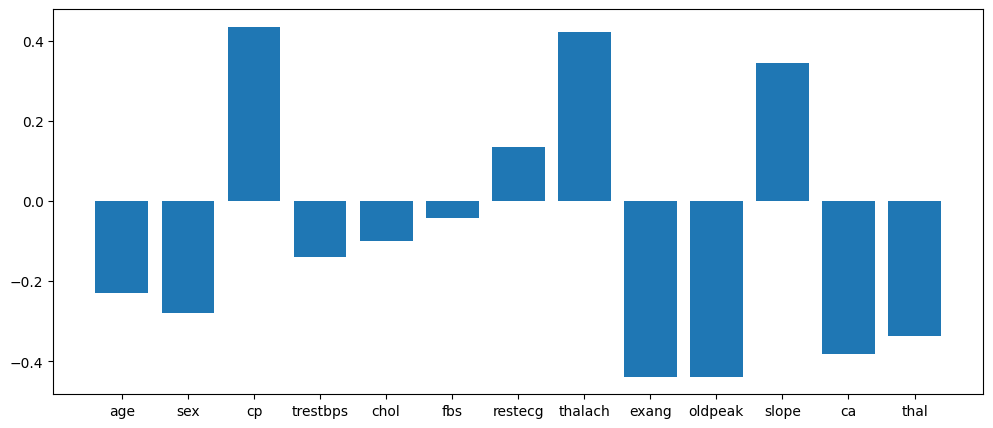

Dropped columns :  ['trestbps', 'chol', 'fbs', 'restecg']


,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,168,0,1.0,2,2,3,0
1,53,1,0,155,1,3.1,0,0,3,0
2,70,1,0,125,1,2.6,0,0,3,0
3,61,1,0,161,0,0.0,2,1,3,0
4,62,0,0,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,164,1,0.0,2,0,2,1
1021,60,1,0,141,1,2.8,1,1,3,0
1022,47,1,0,118,1,1.0,1,1,2,0
1023,50,0,0,159,0,0.0,2,0,2,1


In [215]:
#Correlation analysis and feature reduction

corr_limit = 0.2

corr = data.corr()
x = list((corr.columns)[:-1])
y =list((corr.iloc[-1,:]).iloc[:-1])

plt.figure(figsize=(12,5))
plt.bar(x,y)
plt.show()

drop = []
for i in range(len(x)):
    if(y[i]<=corr_limit and y[i]>=(-corr_limit)):
        drop.append(x[i])

print("Dropped columns : ",drop)
data.drop(drop,axis=1,inplace=True)
data


In [187]:
#Data conversion to tensor 
x_data = []
y_data = []

for i in range(len(data)):
    x_data.append(list(data.iloc[i,:-1]))
    y_data.append([data.iloc[i,-1]])

x_data = torch.tensor(x_data,dtype=torch.float32).to(device)
y_data = torch.tensor(y_data,dtype=torch.float32).to(device)

print("Input",x_data)
print("Output",y_data)

input_count,input_dim = x_data.shape
output_count,output_dim = y_data.shape

print("Input Dimension : ",input_dim)
print("Output Dimension : ",output_dim)

Input tensor([[52.,  1.,  0.,  ...,  2.,  2.,  3.],
        [53.,  1.,  0.,  ...,  0.,  0.,  3.],
        [70.,  1.,  0.,  ...,  0.,  0.,  3.],
        ...,
        [47.,  1.,  0.,  ...,  1.,  1.,  2.],
        [50.,  0.,  0.,  ...,  2.,  0.,  2.],
        [54.,  1.,  0.,  ...,  1.,  1.,  3.]], device='cuda:0')
Output tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]], device='cuda:0')
Input Dimension :  9
Output Dimension :  1


In [188]:
#Building the Neural Network

class neuralnet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(neuralnet,self).__init__()
        self.layer1 = nn.Linear(input_dim,input_dim*4)
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(input_dim*4,input_dim*10)
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(input_dim*10,input_dim*6)
        self.dropout3 = nn.Dropout(0.2)
        self.layer4 = nn.Linear(input_dim*6,input_dim*4)
        self.layertmp = nn.Linear(input_dim,input_dim*4)
        self.norm = nn.LayerNorm(input_dim*4)

        self.layer5 = nn.Linear(input_dim*4,output_dim)
        self.af = nn.GELU()

        self.loss=nn.BCELoss()

    def forward(self,x,y=None):

        if(y==None):
            with torch.no_grad():

                tmp = x
                out = self.layer1(x)
                out = self.layer2(out)
                out = self.af(out)
                out = self.layer3(out)
                out = self.af(out)
                out = self.layer4(out)
                out = self.af(out)

                tmp = self.layertmp(tmp)
                tmp = self.norm(tmp)
                
                out = out + tmp
                out = self.layer5(out)
                out = torch.sigmoid(out)


                return out
        else:
            
            tmp = x
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.af(out)
            out = self.dropout1(out)
            out = self.layer3(out)
            out = self.af(out)
            out = self.dropout2(out)
            out = self.layer4(out)
            out = self.af(out)
            out = self.dropout3(out)

            tmp = self.layertmp(tmp)
            tmp = self.norm(tmp)
            
            out = out + tmp
            out = self.layer5(out)

            out = torch.sigmoid(out)

            error = self.loss(out,y)

            return out,error


In [189]:
def get_batch(batch_size):
    # Get a random index to select the batch from the data
    idx = torch.randperm(x_data.size(0))[:batch_size]
    # Get the batch tensors based on the selected index
    x_batch = x_data[idx]
    y_batch = y_data[idx]
    return x_batch, y_batch

In [190]:
model = neuralnet(input_dim,output_dim).to(device)
a,b = get_batch(5)

#Testing the build
with torch.no_grad():
    y_predicted,loss = model(a,b)

print("Predicted Result : ",y_predicted)
print("Loss : ",loss)

Predicted Result :  tensor([[0.6463],
        [0.6683],
        [0.8551],
        [0.9350],
        [0.6215]], device='cuda:0')
Loss :  tensor(0.5275, device='cuda:0')


after 9, Loss =  0.8117271065711975Var =  nan
after 19, Loss =  0.70574951171875Var =  0.0056156255304813385
after 29, Loss =  0.7026508450508118Var =  0.0038564137648791075
after 39, Loss =  0.6245933175086975Var =  0.005903070326894522
after 49, Loss =  0.6119464039802551Var =  0.006396771874278784
after 59, Loss =  0.6737107634544373Var =  0.0051691774278879166
after 69, Loss =  0.5992223620414734Var =  0.005443647038191557
after 79, Loss =  0.6219761371612549Var =  0.00502619007602334
after 89, Loss =  0.6456143260002136Var =  0.004458406940102577
after 99, Loss =  0.5807119011878967Var =  0.004696494434028864
after 109, Loss =  0.5994870066642761Var =  0.00453586969524622
after 119, Loss =  0.6190984845161438Var =  0.004216433968394995
after 129, Loss =  0.5511531829833984Var =  0.0046122120693326
after 139, Loss =  0.562806248664856Var =  0.004706831183284521
after 149, Loss =  0.6433318853378296Var =  0.004373776726424694
after 159, Loss =  0.5079362392425537Var =  0.00512197008

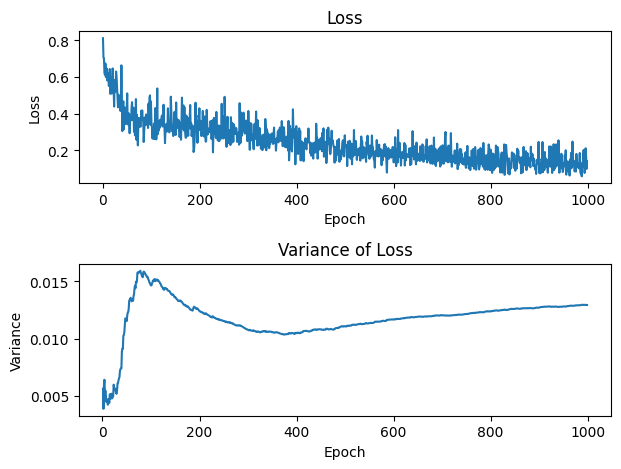

In [191]:
learning_rate = 0.0005
epochs = 10000
optimiser = torch.optim.Adam(model.parameters(),learning_rate)

losses = []
variances = []

for i in range(epochs):

    a,b = get_batch(100)
    y_predicted,loss = model(a,b)
    #Calculate Loss
    loss.backward()
    #Update Weights
    optimiser.step()
    #Zero the gradients ater updating
    optimiser.zero_grad()

    if(i+1)%10 == 0:
        print(f"after {i}, Loss = ", loss.item(), end = "")
        losses.append(loss.item())

        # calculate variance
        var = torch.var(torch.tensor(losses))
        print(f"Var = ", var.item())
        variances.append(var.item())

# plot losses
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# plot variances
plt.subplot(2, 1, 2)
plt.plot(variances)
plt.title('Variance of Loss')
plt.xlabel('Epoch')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()

In [194]:
x = x_data[1020]
y = y_data[1020]

p = model(x)

print("Predicted : ",p)
print("Actual : ",y)

Predicted :  tensor([0.9998], device='cuda:0')
Actual :  tensor([1.], device='cuda:0')


In [208]:
torch.save(model,'engine_nn.CookieNeko')

In [209]:
bla = torch.load('engine_nn.CookieNeko')
bla = bla.to(device)

x = x_data[1020].to(device)
y = y_data[1020].to(device)

p = bla(x)

print("Predicted : ",p)
print("Actual : ",y)

Predicted :  tensor([0.9998], device='cuda:0')
Actual :  tensor([1.], device='cuda:0')


c:\Users\DELL PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\DELL PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


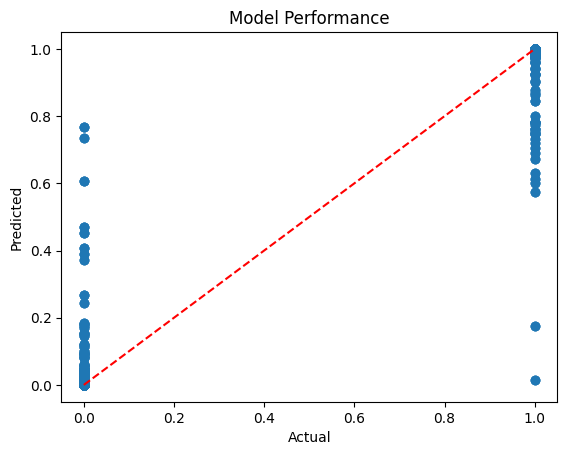

In [198]:


predicted = []
for i in range(len(x_data)):
    p = model(x_data[i]).cpu()
    predicted.append(p.detach().numpy())

x_data = x_data.cpu()
y_data = y_data.cpu()

plt.scatter(y_data, predicted)
plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Performance')
plt.show()
